In [42]:
import salem
import cleo
import pyproj
import numpy as np
from scipy.interpolate import griddata
from eod import msg
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

In [3]:
ind_dic={ '845' : [0,300, 0, 400, 30, 400, 0, -1], }
    
   
    
# make a salem grid
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
    
sav_mcs={'845' : {'lat' : [], 'lon' : [], 'dmin' : [], 'date' : [], 'trmm' : [], 'msg' : [] }}
 
HOD=range(24)   # hours of day
YRANGE=range(2004,2014)

tpath= "/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA/"
tf=msg.extract_TRMMfile(tpath, hod=HOD, yrange=YRANGE, mtresh=1)    
   
tnb=np.array(range(len(tf['fpath'])))
maxs=[]
for tp in tnb:
        dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=tp)
        td=dtrmm['pcp'].mean().max()
        maxs.append(td)
sort_max, sort_nbs = zip(*sorted(zip(maxs, tnb), reverse=True))

In [8]:
for nb in ind_dic.keys():
    nb=nb

In [9]:
nbn=int(nb)
mi=tf['tmins'][nbn]
date=tf['date'].get_str([nbn])
dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=nbn)       

In [10]:
md=dmsg['t']
tlat=dtrmm['lats']
tlon=dtrmm['lons']
td=dtrmm['pcp']
        
dy1=ind_dic[nb][0]
dy2=ind_dic[nb][1]
dx1=ind_dic[nb][2]
dx2=ind_dic[nb][3]
tdy1=ind_dic[nb][4]
tdy2=ind_dic[nb][5]
tdx1=ind_dic[nb][6]
tdx2=ind_dic[nb][7]
        
mlat=dmsg['lats'][dy1:dy2, dx1:dx2]
mlon=dmsg['lons'][dy1:dy2, dx1:dx2]
tlat=dtrmm['lats'][tdy1:tdy2, tdx1:tdx2]
tlon=dtrmm['lons'][tdy1:tdy2, tdx1:tdx2]                                      

In [14]:
md.shape

(580, 1640)

In [15]:
# Transform lon, lats to the mercator projection
mx, my = pyproj.transform(salem.wgs84, proj, mlon, mlat)
tx, ty = pyproj.transform(salem.wgs84, proj, tlon, tlat)
        
ax=mx.flatten().tolist()
ax.extend(tx.flatten().tolist())
ay=my.flatten().tolist()
ay.extend(ty.flatten().tolist())
        
# take the min and max
xmax, xmin = max(ax), min(ax)
ymax, ymin = max(ay), min(ay)

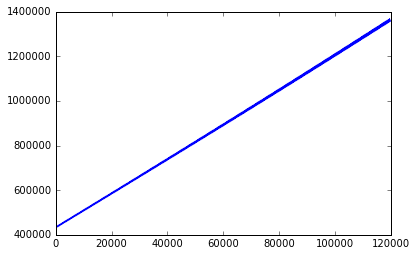

In [44]:
plt.plot(my.flatten())

In [37]:
#Count the number of pixels
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx) 

409413.28242579196

In [45]:
# Here one could add + 1 to be sure that the last pixel is always included
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)        
xi, yi = grid.ij_coordinates
lon, lat = grid.ll_coordinates

In [81]:
min(lon.flatten())

-18.299999999999997

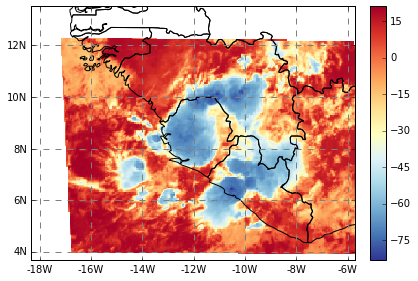

In [65]:
cm = cleo.Map(grid)
cm.set_cmap(plt.cm.RdYlBu_r)
cm.set_nlevels(256)
cm.set_data(outm)
cm.visualize()

In [54]:
xm, ym = grid.transform(mlon.flatten(), mlat.flatten(), crs=salem.wgs84)
xt, yt = grid.transform(tlon.flatten(), tlat.flatten(), crs=salem.wgs84)
        
# Convert for griddata input 
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T
        
# Interpolate using delaunay triangularization 
outm = griddata(mpoints, md[dy1:dy2, dx1:dx2].flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))
        
# Interpolate using delaunay triangularization 
outt = griddata(tpoints, td[tdy1:tdy2, tdx1:tdx2].flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx))
        
        

In [109]:
outt.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [86]:
sav_mcs[nb]['lat']=lat
sav_mcs[nb]['lon']=lon
sav_mcs[nb]['dmin']=mi 
sav_mcs[nb]['date']=date
sav_mcs[nb]['trmm']=outt
sav_mcs[nb]['msg']=outm

In [154]:
date[0]

'20110925 04:30:00'

In [88]:
mc=sav_mcs['845']

In [89]:
mc.keys()

dict_keys(['trmm', 'msg', 'date', 'lat', 'lon', 'dmin'])

In [90]:
mc['dmin']

27

In [91]:
savefile = '/users/global/cornkle/mt_wavelet_test.p'
pkl.dump(sav_mcs, open(savefile, 'wb'))

In [192]:
import xray
dic = xray.open_dataset('/users/global/cornkle/wtest/845_mt_wavelet_test.nc')

In [193]:
tr=dic.trmm.values

In [194]:
msg=dic.msg.values

In [195]:
msg

array([[ -5.84599403e+000,   2.51285712e+000,   1.33987221e+001, ...,
          1.40465069e+001,   1.36066524e+001,   1.37968004e+001],
       [  1.30000000e+001,   1.33975376e+001,   1.35624449e+001, ...,
         -6.94948274e+001,  -7.27210899e+001,  -7.40257202e+001],
       [ -7.48559845e+001,  -7.45809106e+001,  -7.20810459e+001, ...,
         -5.62406705e+001,  -5.79807553e+001,  -5.84713425e+001],
       ..., 
       [ -5.74980206e-214,  -4.14831749e-210,  -2.93797652e-206, ...,
         -2.18333834e-094,  -1.60721342e-090,  -1.16804491e-086],
       [ -8.35142115e-083,  -5.84435169e-079,  -4.19628012e-075, ...,
         -2.72080552e-234,  -1.44527663e-226,  -7.60577082e-219],
       [ -3.75076431e-211,  -2.04572236e-203,  -1.05652799e-195, ...,
         -6.01862817e+028,  -3.05680746e+036,  -1.10707245e-234]])

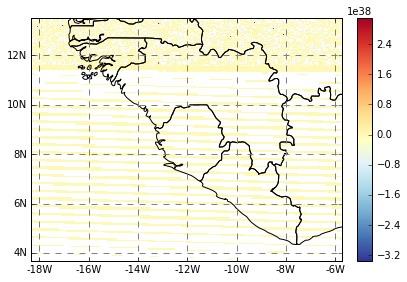

In [191]:
cm = cleo.Map(grid)
cm.set_cmap(plt.cm.RdYlBu_r)
cm.set_nlevels(256)
cm.set_data(tr)
cm.visualize()

In [120]:
trmm=item['trmm']
msg=item['msg']

In [121]:
trmm.shape

(220, 281)

In [122]:
msg.shape

(220, 281)